In [2]:
from model import util, SimpleGRU
from data import SlidingWinDataset

import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.functional import l1_loss, mse_loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

sns.set()

# Config

In [3]:
cluster_data_path = '../data/cluster/fft_agg_cluster_4.csv'

SLIDING_WIN = 10
BATCH_SIZE = 8
SHUFFLE = True

NUM_EPOCH = 1000

# Data Preparation

In [4]:
cluster = pd.read_csv(cluster_data_path, index_col=0)
cluster

,index
agg cluster,
0,"[9003, 9039, 9164, 9200, 9207, 9490]"
1,"[9053, 9077, 9472]"
2,"[9008, 9012]"
3,"[9025, 9049]"


In [5]:
train_data = pd.read_csv('../data/13series_time_stacked_cash/train.csv').drop(['日期'], axis=1).astype(float)
test_data = pd.read_csv('../data/13series_time_stacked_cash/test.csv').drop(['日期'], axis=1).astype(float)

valid_data = train_data.iloc[-20:, :]
train_data = train_data.iloc[:-20, :]

INPUT_DIM = train_data.shape[-1]

In [6]:
train_data

,尾箱余额_9012,尾箱余额_9003,尾箱余额_9049,尾箱余额_9025,尾箱余额_9053,尾箱余额_9077,尾箱余额_9207,尾箱余额_9200,尾箱余额_9164,尾箱余额_9008,尾箱余额_9039,尾箱余额_9472,尾箱余额_9490
0,600.0,270200.0,13900.0,25500.0,184300.0,90500.0,89400.0,271300.0,159800.0,173300.0,221100.0,72600.0,555800.0
1,504000.0,270200.0,456500.0,617000.0,159500.0,56500.0,42700.0,227900.0,87900.0,173300.0,227300.0,101600.0,145800.0
2,467300.0,262500.0,306500.0,565400.0,154100.0,66900.0,195900.0,136600.0,121300.0,169600.0,250300.0,75100.0,234600.0
3,382200.0,108300.0,293200.0,529500.0,259800.0,421400.0,285400.0,14300.0,96600.0,139700.0,140300.0,49000.0,300700.0
4,298700.0,428700.0,293200.0,543600.0,288300.0,432400.0,298800.0,487100.0,266400.0,194000.0,152900.0,307900.0,580300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,395200.0,370300.0,150900.0,122700.0,356200.0,490400.0,102700.0,243300.0,153800.0,213500.0,202200.0,574300.0,102200.0
356,304200.0,363100.0,91600.0,19700.0,366600.0,600000.0,87200.0,120700.0,160800.0,213500.0,217300.0,619400.0,354100.0
357,210800.0,318900.0,91600.0,616000.0,332300.0,570700.0,45900.0,29600.0,232900.0,0.0,248200.0,655400.0,365300.0
358,101900.0,247800.0,900.0,615400.0,472300.0,553600.0,40200.0,329400.0,165100.0,99800.0,235400.0,319200.0,483800.0


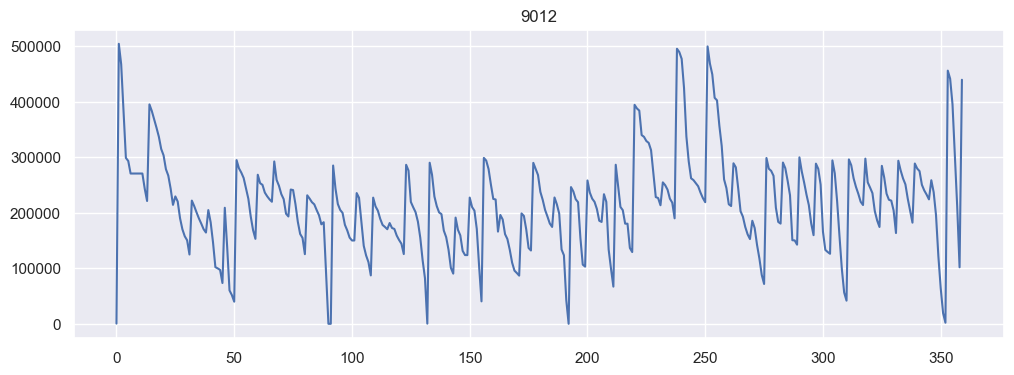

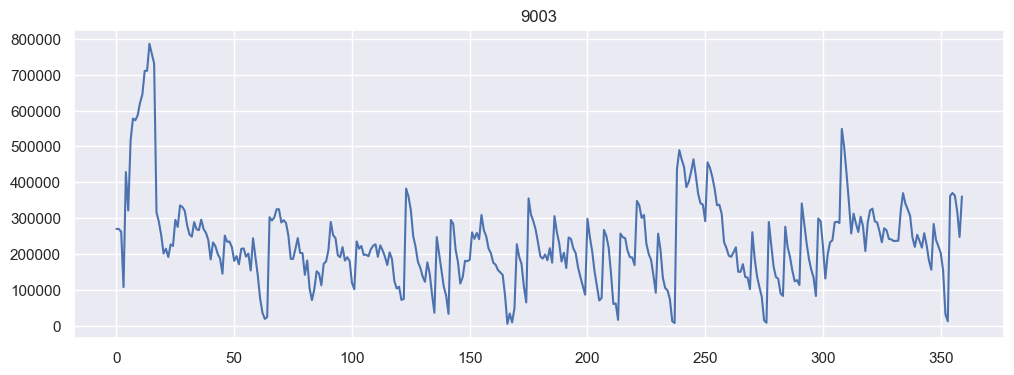

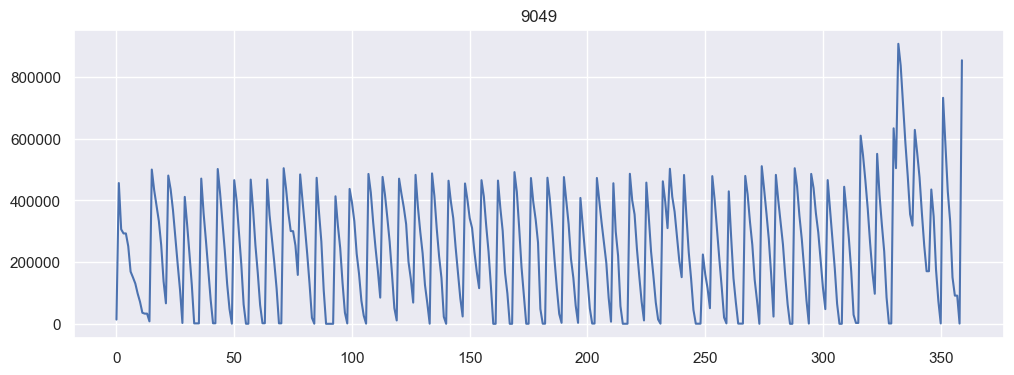

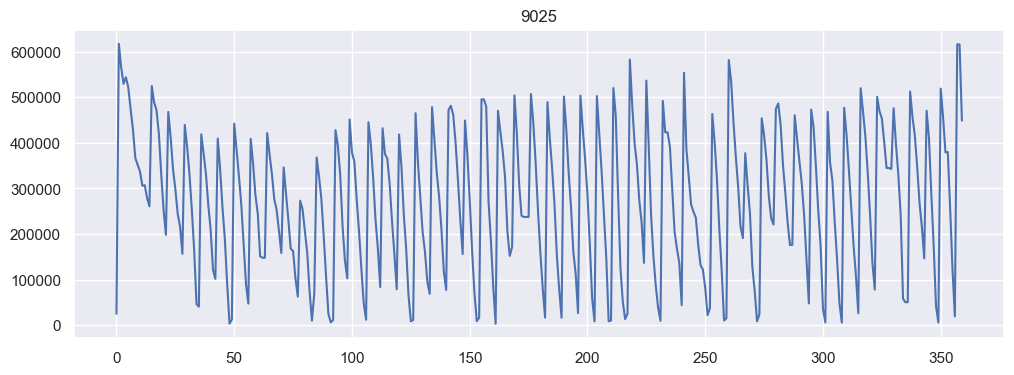

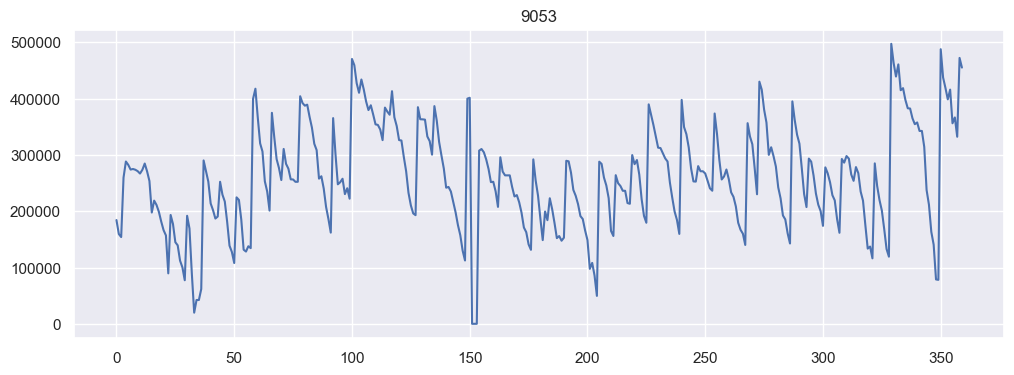

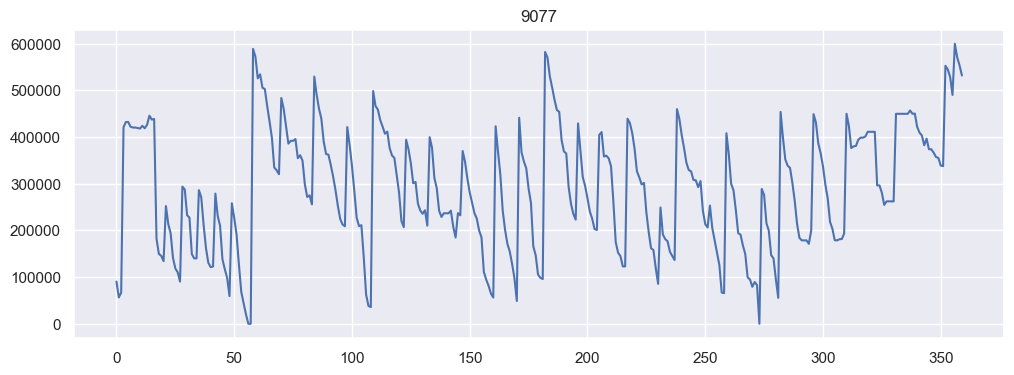

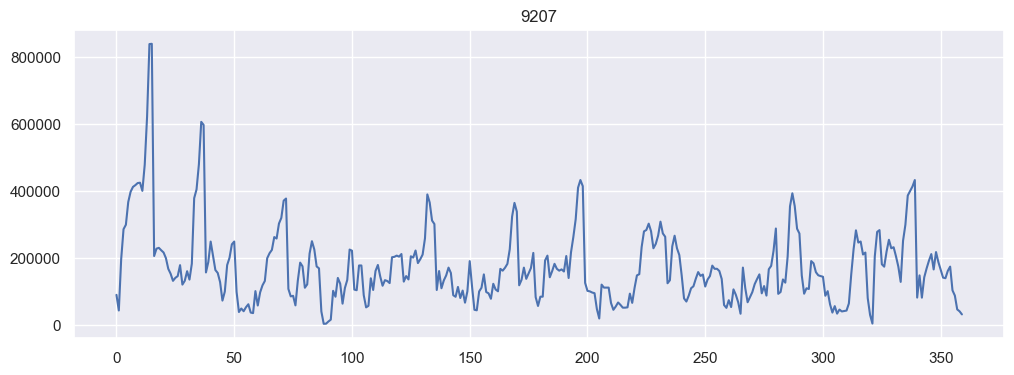

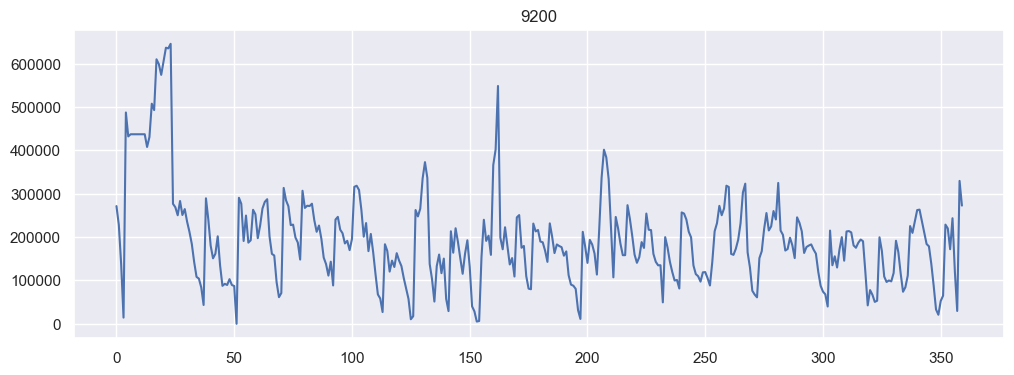

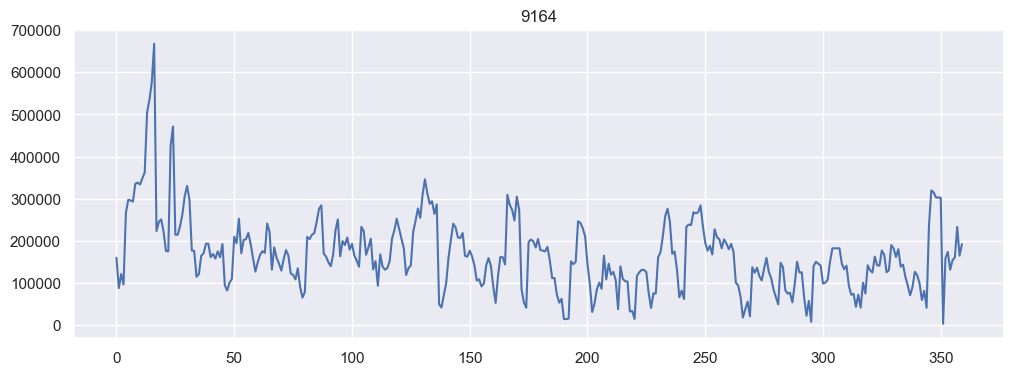

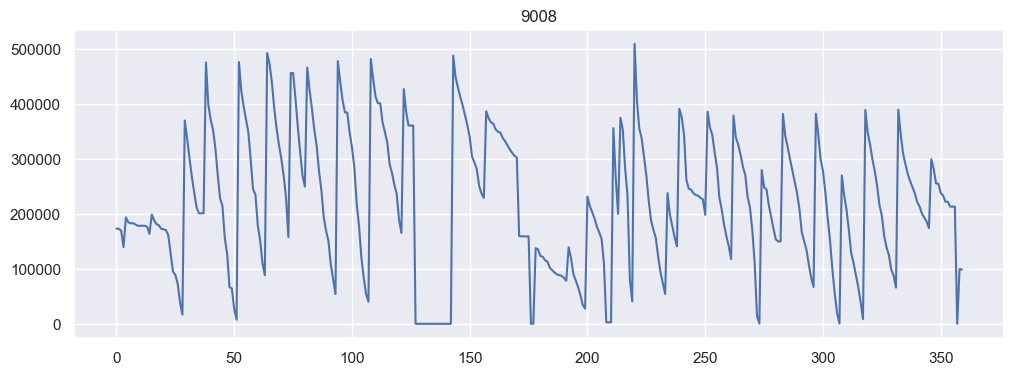

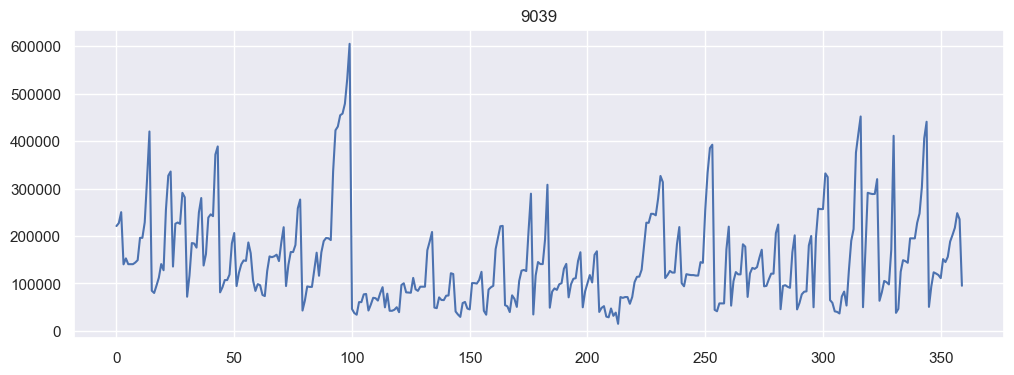

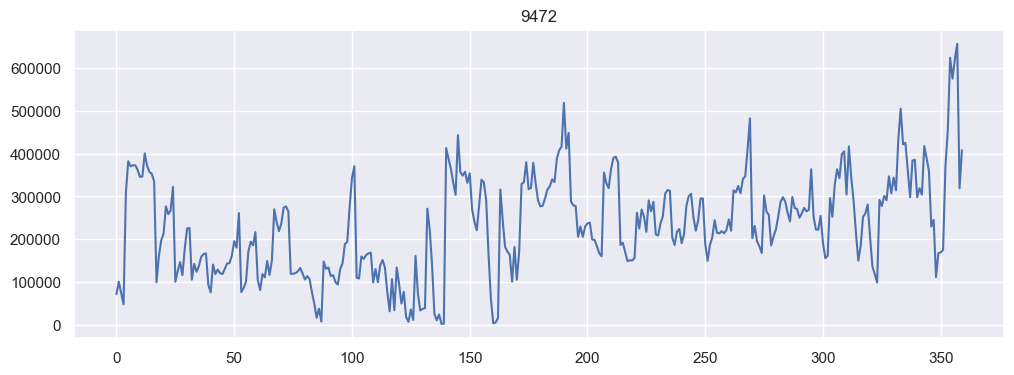

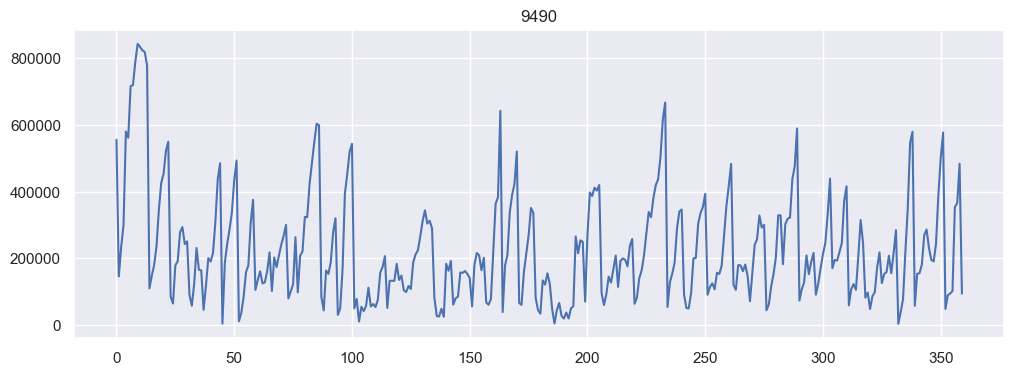

In [19]:
for col in train_data.columns:
    train_data[col].plot(figsize=(12, 4))
    plt.title(col)
    plt.show()

In [7]:
train_data.columns = [int(col.split('_')[-1]) for col in train_data.columns]

In [8]:
train_data

,9012,9003,9049,9025,9053,9077,9207,9200,9164,9008,9039,9472,9490
0,600.0,270200.0,13900.0,25500.0,184300.0,90500.0,89400.0,271300.0,159800.0,173300.0,221100.0,72600.0,555800.0
1,504000.0,270200.0,456500.0,617000.0,159500.0,56500.0,42700.0,227900.0,87900.0,173300.0,227300.0,101600.0,145800.0
2,467300.0,262500.0,306500.0,565400.0,154100.0,66900.0,195900.0,136600.0,121300.0,169600.0,250300.0,75100.0,234600.0
3,382200.0,108300.0,293200.0,529500.0,259800.0,421400.0,285400.0,14300.0,96600.0,139700.0,140300.0,49000.0,300700.0
4,298700.0,428700.0,293200.0,543600.0,288300.0,432400.0,298800.0,487100.0,266400.0,194000.0,152900.0,307900.0,580300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,395200.0,370300.0,150900.0,122700.0,356200.0,490400.0,102700.0,243300.0,153800.0,213500.0,202200.0,574300.0,102200.0
356,304200.0,363100.0,91600.0,19700.0,366600.0,600000.0,87200.0,120700.0,160800.0,213500.0,217300.0,619400.0,354100.0
357,210800.0,318900.0,91600.0,616000.0,332300.0,570700.0,45900.0,29600.0,232900.0,0.0,248200.0,655400.0,365300.0
358,101900.0,247800.0,900.0,615400.0,472300.0,553600.0,40200.0,329400.0,165100.0,99800.0,235400.0,319200.0,483800.0


In [9]:
train_data[eval(cluster['index'][0])]

,9003,9039,9164,9200,9207,9490
0,270200.0,221100.0,159800.0,271300.0,89400.0,555800.0
1,270200.0,227300.0,87900.0,227900.0,42700.0,145800.0
2,262500.0,250300.0,121300.0,136600.0,195900.0,234600.0
3,108300.0,140300.0,96600.0,14300.0,285400.0,300700.0
4,428700.0,152900.0,266400.0,487100.0,298800.0,580300.0
...,...,...,...,...,...,...
355,370300.0,202200.0,153800.0,243300.0,102700.0,102200.0
356,363100.0,217300.0,160800.0,120700.0,87200.0,354100.0
357,318900.0,248200.0,232900.0,29600.0,45900.0,365300.0
358,247800.0,235400.0,165100.0,329400.0,40200.0,483800.0


In [10]:
train_set = SlidingWinDataset(train_data, SLIDING_WIN)
valid_set = SlidingWinDataset(valid_data, SLIDING_WIN)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_loader = DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

# Model Definition, Train, Test

In [11]:
HIDDEN_DIM = 10
model = SimpleGRU(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=INPUT_DIM,
    train_h0=True
)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# metrics = [mean_squared_error, root_mean_squared_error, mean_absolute_error]
metrics = [l1_loss]

save_dir = f'../log/SimpleGRU(norm, h0 trainable, win={SLIDING_WIN}, batch_size={BATCH_SIZE})/'

C:\Users\LiuShu\miniconda3\envs\main\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [12]:
assert False

@torch.no_grad()
def test(_test_loader) -> np.ndarray:
    # results = []
    for b, (X, y) in enumerate(_test_loader):
        assert b < 1, "Only one batch is expected"
        # print(X.shape)
        # print(y.shape)
        # assert False
        y_pred = model(X, torch.zeros(1, X.shape[0], HIDDEN_DIM, dtype=torch.float))
        batch_results = [metrics_fn(y, y_pred).item() for metrics_fn in metrics]
    
        if loss_fn is not None:
            loss = loss_fn(y_pred, y).item()
            batch_results = [loss] + batch_results
            
        return batch_results
    #     results.append(batch_results)
    # return np.array(results).mean(axis=0).tolist()


# for e in range(0, NUM_EPOCH):
for e in range(NUM_EPOCH, NUM_EPOCH * 2):
    epoch_loss = []
    for b, (X, y) in enumerate(train_loader):
        y_pred = model(X, torch.zeros(1, X.shape[0], HIDDEN_DIM, dtype=torch.float))
        # print(y.shape)
        # print(y_pred.shape)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    epoch_valid_results = test(valid_loader)
    util.log_train(e, model, epoch_loss, epoch_valid_results, save_dir=save_dir)    

AssertionError: 

In [13]:
util.load_checkpoint(model, save_dir, '2024-05-22-12-45', epoch=70)

y_list = []
y_pred_list = []

h0 = torch.zeros(1, HIDDEN_DIM)
for i in range(len(train_set)):
    X, y = train_set[i]
    y_pred = model(X, h0)
    y_pred_list.append(y_pred)
    y_list.append(y)
    
    
y_list2 = []
y_pred_list2 = []

h0 = torch.zeros(1, HIDDEN_DIM)
for i in range(len(valid_set)):
    X, y = valid_set[i]
    y_pred = model(X, h0)
    y_pred_list2.append(y_pred)
    y_list2.append(y)

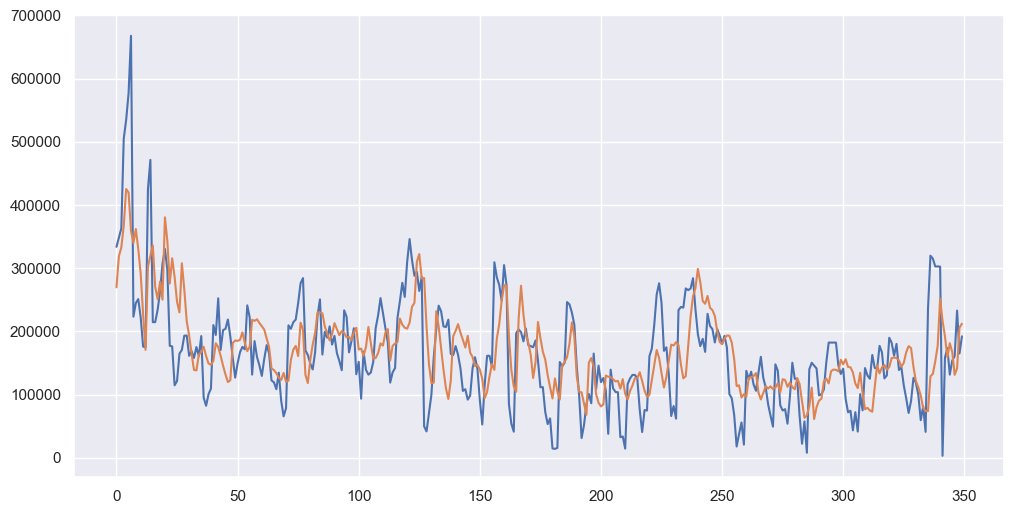

In [20]:
s = 8

plt.figure(figsize=(12, 6))
plt.plot(torch.stack(y_list, dim=0)[:, s])
plt.plot(torch.squeeze(torch.stack(y_pred_list, dim=0), dim=1).detach()[:, s])

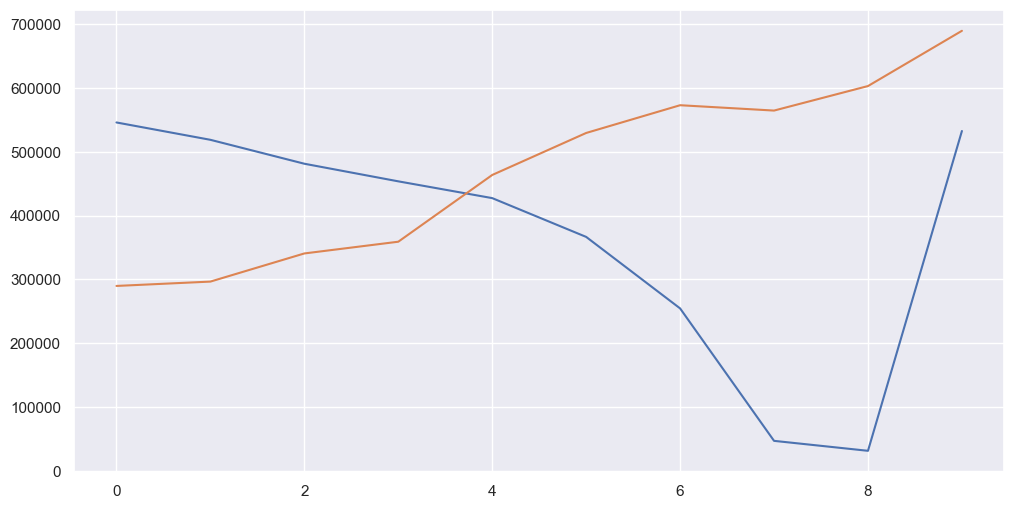

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(torch.stack(y_list2, dim=0)[:, s])
plt.plot(torch.squeeze(torch.stack(y_pred_list2, dim=0), dim=1).detach()[:, 12])

In [ ]:
util.visualize_train(
    os.path.join('../log/SimpleGRU(norm, h0 trainable, win=10, batch_size=8)', '2024-05-22-12-45'), 
    ['test_loss', 'MAE'],
    v_lines = [50, 80]
)